# Spatiotemporal trajectory of mouse organogenesis

In this tutorial, we showcase the use of {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`, which combines gene expression with spatial information, to analyze the spatiotemporal trajectory in mouse organogenesis.

:::{note}
We recommend running this tutorial on a GPU.
:::

:::{seealso}
- See {doc}`200_temporal_problem` on how to link cells across time points without spatial information.
:::

## Mapping cells across time incorporating spatial information

The advent of spatially-resolved single-cell datasets of developmental systems enables the characterization of cellular differentiation in space and time. We can utilize OT to learn a matching between cellular states within spatiotemporal datasets by defining a FGW-type problem {cite}`vayer:2020`. In this setup we incorporate similarities at gene expression across time points (W term) and physical distances within time point (GW term).

Additionally, we use entropic regularization {cite}`cuturi:2013` to speed up computations and to improve the statistical properties of the solution {cite}`peyre:19`. In the objective function, we compare $N$ early to $M$ late cells. We use the following definitions: 

- $P \in \mathbb{R}^{N \times M}$: coupling matrix we seek to learn; it probabilistically relates early to late cells. 
- $C$: cost matrix between early and late cells; it quantifies how "expensive" it is to move along the phenotypic landscape. Typically, it represents Euclidean distance in a gene expression-based latent space like PCA or scVI {cite}`lopez2018deep`. 
- $C^X$ and $C^Y$: cost matrices among early and late cells, respectively. These quantify physical distances between the cells. Typically using the l2 distance over {attr}`obsm['spatial'] <anndata.AnnData.obsm>`. 
- $\varepsilon$: weight given to entropic regularitation. Larger values will lead to more "blurred" couplings. 
- $\alpha$: weight given to OT (gene expression) vs. GW (spatial information) terms.

## Preliminaries

In [14]:
import warnings

import moscot as mt
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.spatiotemporal import SpatioTemporalProblem

import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Dataset description

The {func}`~moscot.datasets.mosta` dataset is a subset of the spatiotemporal transcriptomics atlas of mouse organogenesis {cite}`chen:22`. 

The {class}`~anndata.AnnData` object includes read-outs at three time points with embryo sections `E9.5_E2S1`, `E10_E2S1`, and `E11.5_E1S2`. The data was preprocessed by normalizing and log-transforming the counts.

In [22]:
adata = datasets.mosta()
adata.obs["time"] = adata.obs["time"].astype("category")
adata

AnnData object with n_obs × n_vars = 54134 × 2000
    obs: 'annotation', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'time', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'Heart_mapping', 'Heart_annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Heart_annotation_colors', 'annotation_colors', 'hvg', 'moscot_results'
    obsm: 'spatial'
    layers: 'count'

## Visualise the data

We consider the cell type annotations in spatial coordinates.

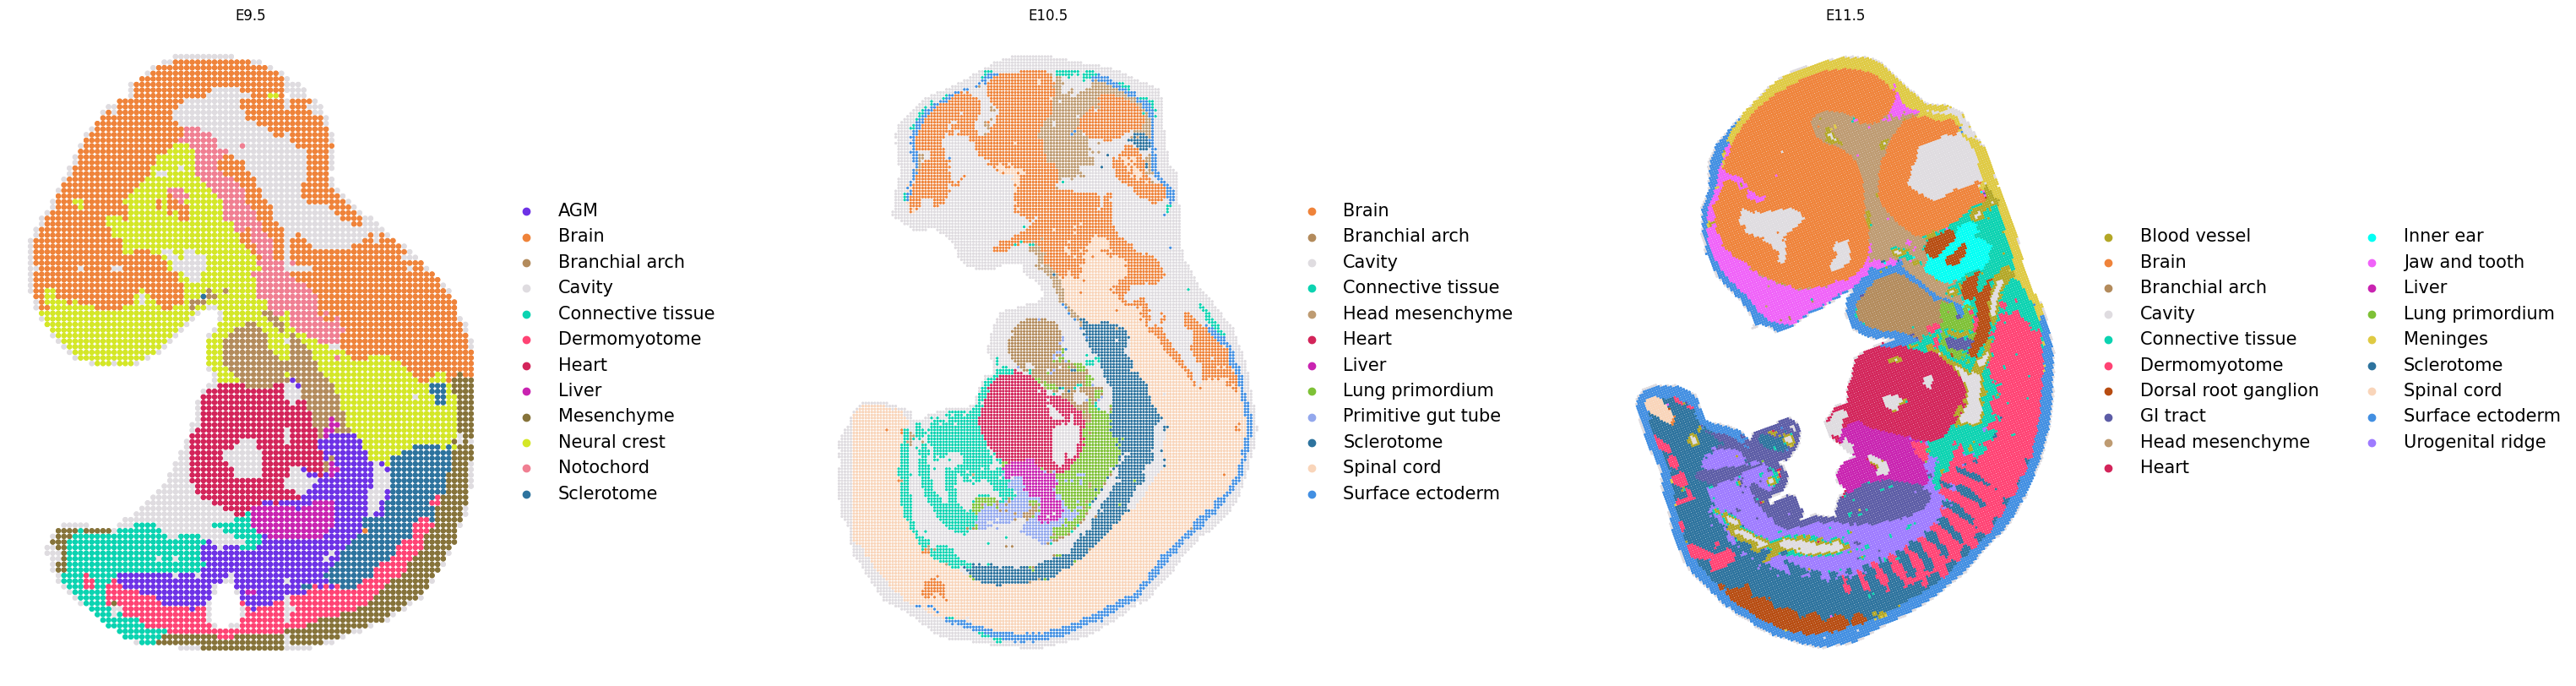

In [15]:
library_ids = list(adata.obs["timepoint"].cat.categories)
sq.pl.spatial_scatter(
    adata,
    color="annotation",
    frameon=False,
    shape=None,
    library_key="timepoint",
    library_id=library_ids,
    title=library_ids,
    figsize=(10, 10),
    size=[50, 5, 5],
    legend_fontsize=15,
)

## Prepare the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`

We start by initializing a problem

In [4]:
stp = SpatioTemporalProblem(adata)

We can adapt the marginals of the OT problem. By default, marginals are chosen to be uniform. This means that, even if each cell in the early time point has multiple possible descendants in the later time point, the proportions of the descendants sum up to "the mass of one cell". In developing systems we know that some cells might proliferate more than others. We can account for this by adapting the marginals based on proliferation and apoptosis markers with {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.score_genes_for_marginals`. 

:::{seealso}
- See {doc}`../examples/problems/500_passing_marginals` on how to pass custom marginals. 
:::

In [5]:
stp = stp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

To prepare the problem we need to pass some information:

- `time_key`: defines the {attr}`obs <anndata.AnnData.obs>` column for the temporal information.
- `spatial_key`: defines the {attr}`~anndata.AnnData.obsm` where the spatial coordinates are saved used to claculate $C^X$ and $C^Y$.
- `joint_attr`: defines based on which (latent) space we compute the distances for the W problem, $C$. Here, we do not use a precomputed embedding but hence pass `None` and use a callback.
- `callback`: states which computation should be run on {attr}`~anndata.AnnData.X` to get the joint cost.

:::{seealso}
- See {doc}`../examples/problems/200_custom_cost_matrices` on how to pass precomputed cost matrices. 
- See {doc}`../examples/problems/400_subset_policy` on how to choose pairs of time points between which to compute OT maps. 
:::

In [21]:
stp = stp.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


## Solve the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`

As the data is large, we use low-rank optimal transport to decrease the computational complexity {cite}`scetbon:21a`. 

To solve the problem we pass the following arguments, `alpha` (in $(0, 1]$), which  defines the influence of the spatial coordinates as opposed to the single-cell data. `epsilon`, the entropy parameter, and `initializer='rank2'` to improve the speed of convergence.

:::{seealso}
- See {doc}`../examples/solvers/200_linear_problems_advanced` on how to modify low-rank parameters. 
- See {doc}`../examples/solvers/400_quad_problems_advanced` for an advanced example on how to solve quadratic problems.
:::

In [7]:
stp = stp.solve(alpha=0.5, epsilon=1e-3, rank=100, initializer="rank2")

INFO     Solving `2` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5870, 18292)].                                 
WARNING  Solver did not converge                                                                                   
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(18292, 29972)].                                
WARNING  Solver did not converge                                                                                   


## Cell transitions

We can now analyze which cell types are mapped to which cell type across time using the {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.cell_transition` method. As different time points have different cell types, it is not straightforward to assess the mapping. To improve the visualization, we order the annotations such that in the upper left we have the same cell types.

In [8]:
celltypes_source_1 = adata[adata.obs["time"] == 9.5].obs["annotation"].cat.categories
celltypes_target_1 = adata[adata.obs["time"] == 10.5].obs["annotation"].cat.categories
celltypes_intersection_1 = list(
    set(celltypes_source_1).intersection(celltypes_target_1)
)
source_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_source_1) - set(celltypes_target_1)
)
target_ordered_1 = celltypes_intersection_1 + list(
    set(celltypes_target_1) - set(celltypes_source_1)
)

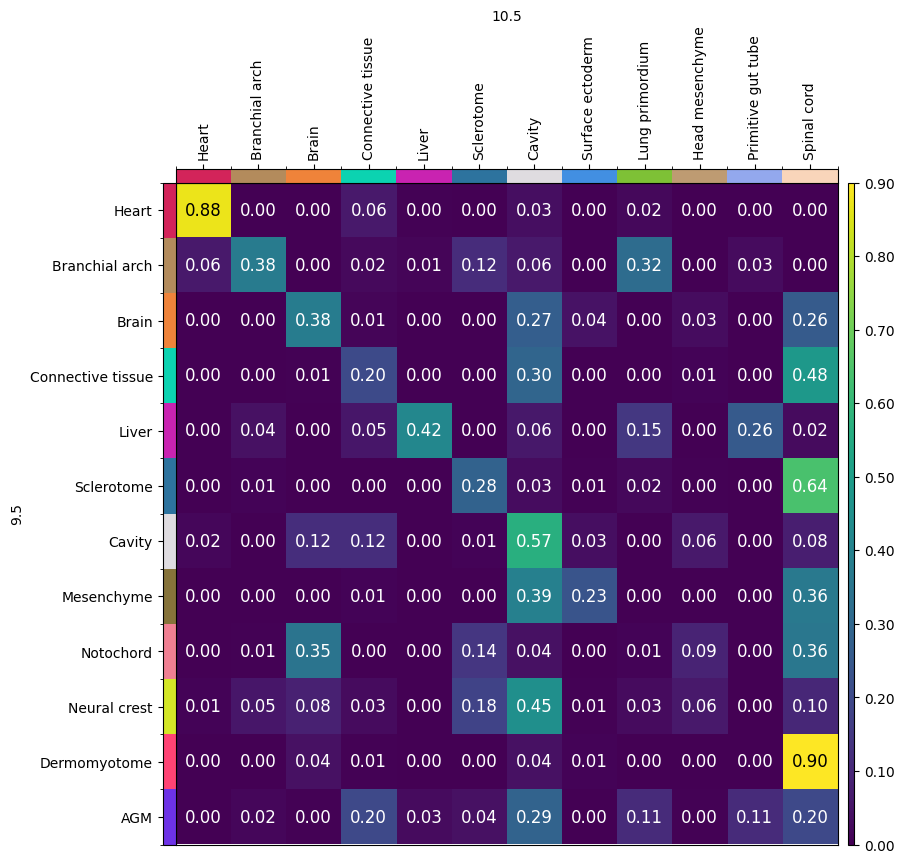

In [16]:
stp.cell_transition(
    source=9.5,
    target=10.5,
    source_groups={"annotation": source_ordered_1},
    target_groups={"annotation": target_ordered_1},
    forward=True,
)
mtp.cell_transition(stp, fontsize=12, figsize=(7, 7))

Most of the cell types seem to map to themselves, such as the `Heart` cells. Moreover, we can see that many cells are mapped to `Cavity`, which is to be expected.

In [17]:
celltypes_source_2 = adata[adata.obs["time"] == 10.5].obs["annotation"].cat.categories
celltypes_target_2 = adata[adata.obs["time"] == 11.5].obs["annotation"].cat.categories
celltypes_intersection_2 = list(
    set(celltypes_source_2).intersection(celltypes_target_2)
)
source_ordered_2 = celltypes_intersection_2 + list(
    set(celltypes_source_2) - set(celltypes_target_2)
)
target_ordered_2 = celltypes_intersection_2 + list(
    set(celltypes_target_2) - set(celltypes_source_2)
)

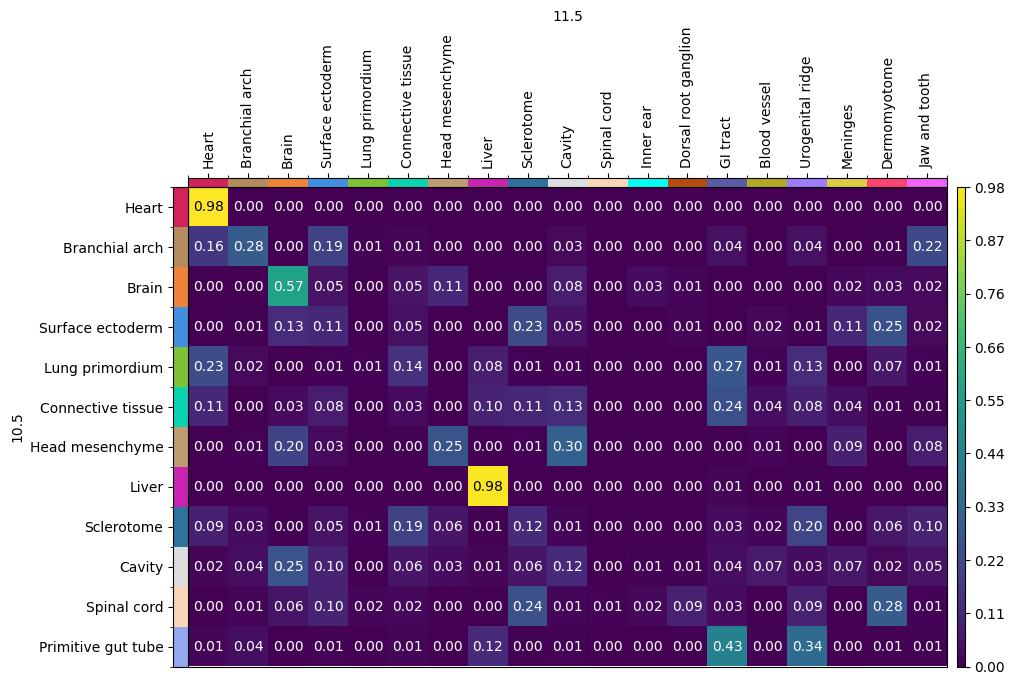

In [18]:
stp.cell_transition(
    source=10.5,
    target=11.5,
    source_groups={"annotation": source_ordered_2},
    target_groups={"annotation": target_ordered_2},
    forward=True,
)
mtp.cell_transition(stp, fontsize=10, figsize=(8, 8))

## Pushing cells across space and time

Next, we can visualize the predicted spatial destination of the cells using the {meth}`~moscot.problems.spatiotemporal.SpatioTemporalProblem.push` method. Below we focus on the `Heart` cells.

In [19]:
for (start, end), prob in stp.problems.items():
    stp.push(
        source=start,
        target=end,
        data="annotation",
        subset="Heart",
        key_added="Heart_mapping",
    )

In the first column, we plot the spatial locations of the heart cells at `E10.5`. In the second row, we show the `Heart` cells projected onto the the spatial coordinates at `E11.5`.

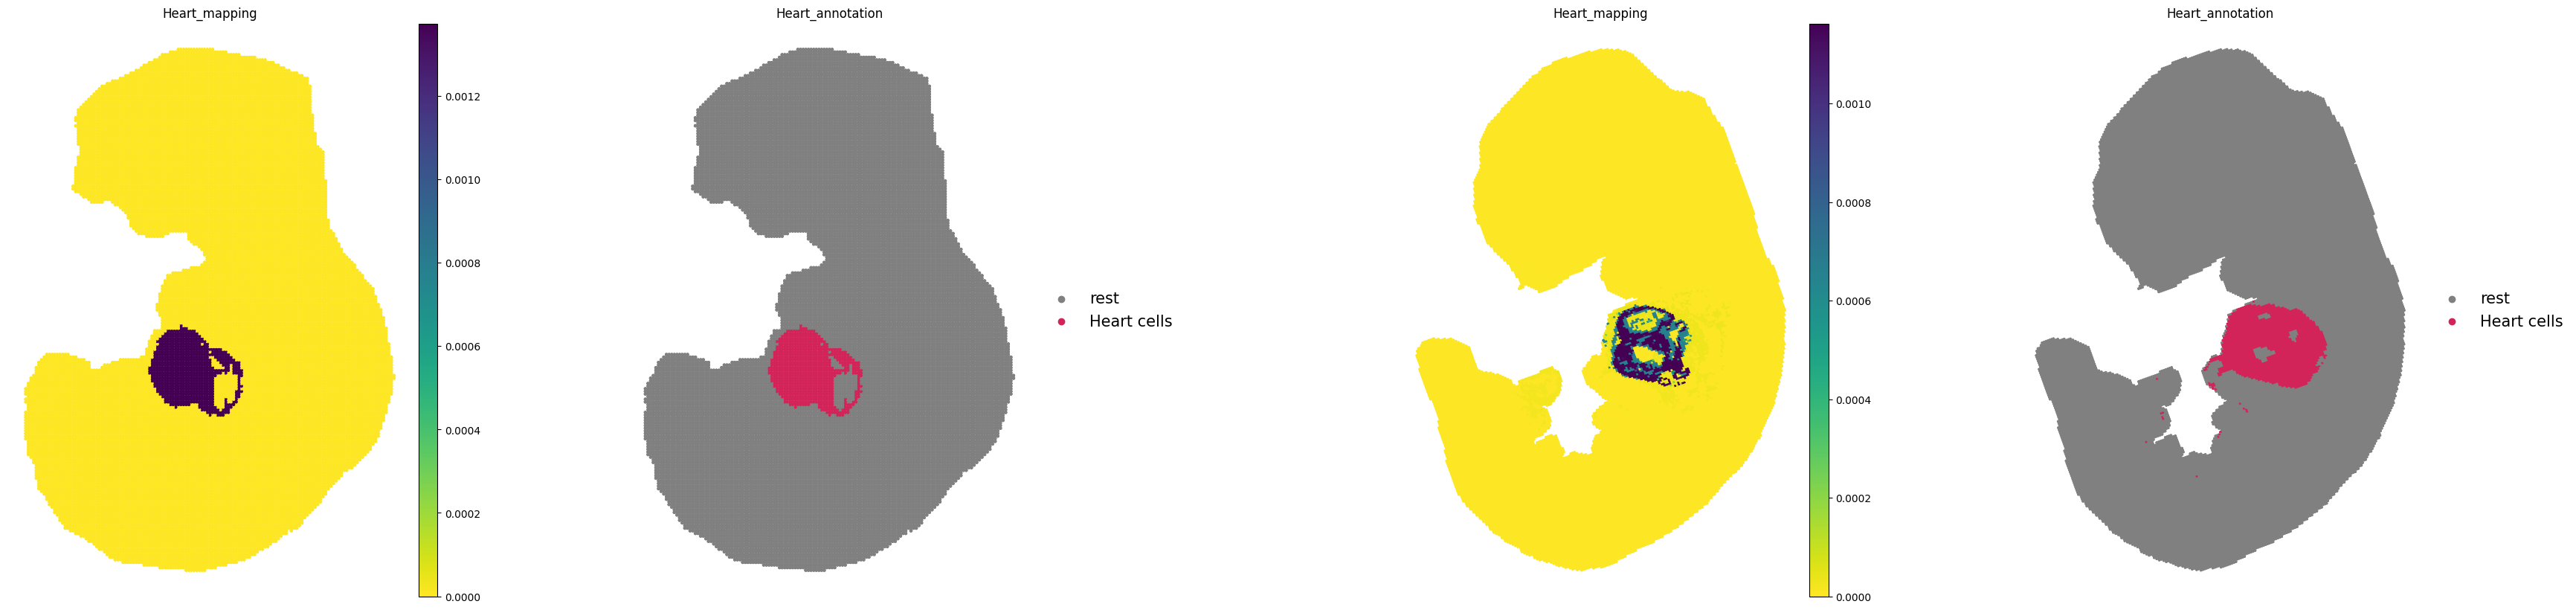

In [20]:
library_ids = ["E10.5", "E11.5"]

sq.pl.spatial_scatter(
    adata,
    color=["Heart_mapping", "Heart_annotation"],
    frameon=False,
    shape=None,
    library_key="timepoint",
    library_id=library_ids,
    cmap="viridis_r",
    figsize=(10, 10),
    size=[20, 10],
    legend_fontsize=15,
)